In [1]:
!pip install spacy==2.3.4
!pip install gensim==3.8.3
!pip install pyldavis==2.1.2
!pip install nltk==3.5
!pip install bokeh==2.2.3
!pip install umap==0.1.1
!pip install umap-learn==0.4.6
!pip install texthero -U

In [5]:
# Import modules

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re, nltk, spacy, gensim

#TextHero

import texthero as hero
import pandas as pd

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

First load the current RSS feed which contains most of the data.

In [81]:
urls = ["https://www.mathjobs.org/jobs?joblist-0-0----rss--",
        "http://web.archive.org/web/20200430170837/http://www.mathjobs.org:80/jobs?joblist-0-0----rss--",
        "http://web.archive.org/web/20191203172915/http://www.mathjobs.org:80/jobs?joblist-0-0----rss--",
        "http://web.archive.org/web/20181214064225/http://mathjobs.org:80/jobs?joblist-0-0----rss--",
        "http://web.archive.org/web/20170804145323/http://www.mathjobs.org:80/jobs?joblist-0-0----rss--",
        "http://web.archive.org/web/20160314084131/http://www.mathjobs.org:80/jobs?joblist-0-0----rss--",
        "http://web.archive.org/web/20150326010633/http://mathjobs.org:80/jobs?joblist-0-0----rss--",
        "http://web.archive.org/web/20140927220841/http://www.mathjobs.org:80/jobs?joblist-0-0----rss--"
        ]

In [7]:
req = requests.get("https://www.mathjobs.org/jobs?joblist-0-0----rss--")

In [8]:
soup = BeautifulSoup(req.text, 'xml')

In [9]:
soup

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF xmlns:="http://purl.org/rss/1.0/" xmlns:admin="http://webns.net/mvcb/" xmlns:ads="https://www.mathjobs.org/jobs/ads.rss" xmlns:content="http://purl.org/rss/1.0/modules/content/" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#" xmlns:syn="http://purl.org/rss/1.0/modules/syndication/" xmlns:taxo="http://purl.org/rss/1.0/modules/taxonomy/">
<channel rdf:about="https://www.mathjobs.org/jobs">
<title>Www.mathjobs.org Job Listing</title>
<link>https://www.mathjobs.org/jobs</link>
<description>Www.mathjobs.org Job Listing</description>
<dc:language>en-us</dc:language>
<dc:rights>(c) Copyright 2021 MathJobs.Org. All Rights Reserved.</dc:rights>
<dc:date>2021-10-25T15:21:08-04:00</dc:date>
<dc:publisher>www.mathjobs.org</dc:publisher>
<syn:updateBase>2000-01-01T12:00:00-05:00</syn:updateBase>
<syn:updateFrequency>1</syn:updateFrequency>
<syn:updatePeriod>daily</syn:updatePeriod>
<items>
<rdf:Seq>


In [10]:
items = soup.find_all("item")

In [11]:
items[3]

<item rdf:about="https://www.mathjobs.org/jobs/list/18745?rss">
<title>Research, Postdoctoral Research Scholar</title>
<link>https://www.mathjobs.org/jobs/list/18745?rss</link>
<description>Postdoctoral Research Scholar Arizona State University School of
   Mathematical and Statistical Sciences The School of Mathematical and
   Statistical Sciences (SoMSS) at Arizona State University (ASU) invites
   applications for Postdoctoral Research Scholar positions with an
   anticipated start date of fall 2022. These full-time academic year,
   benefits-eligible positions are renewable on an annual basis through
   spring 2025 contingent upon satisfactory performance, availability of
   resources, and the needs of the university. Applicants must be within
   five years of receipt of their PhD to be considered for initial
   appointments and subsequent renewals. The School of Mathematical and
   Statistical Sciences is committed to actively recruiting and retaining
   a diverse workforce and st

In [12]:
items[3].title.text

'Research, Postdoctoral Research Scholar'

In [82]:
total_items = []
for url in urls:
    req = requests.get(url)
    soup = BeautifulSoup(req.text, 'xml')
    items = soup.find_all("item")
    total_items.extend(items)

In [83]:
len(total_items)

3757

In [15]:
total_items[13].title.text

'Probability Theory and related fields, Postdoctoral Fellow'

In [84]:
import pandas as pd

rows = []
for item in total_items:
    rows.append([item.title.text, item.link.text, item.description.text, item.creator.text, item.EndDate.text, item.City.text, item.State.text, item.Country.text ])
    
df = pd.DataFrame(rows, columns = ["Title",  "Link", "Description", "Creator", "EndDate", "City", "State", "Country"])

In [17]:
df.shape

(2315, 8)

## Task 2: Clean dataset & Visualize frequent words

In [85]:
#Pass a custom pipeline as argument to clean

from texthero import preprocessing

custom_pipeline = [preprocessing.lowercase,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_urls]
data = hero.clean(df['Description'])

# Final cleaning
data = data.map(lambda x: " ".join([t for t in x.split() if len(t) > 1])  )

In [86]:
data.shape

(3757,)

In [87]:
import texthero as hero

s = pd.Series("I had a good day visting school in the summer but how long did it last?")
hero.remove_punctuation(s)[0]

'I had a good day visting school in the summer but how long did it last '

In [88]:
data.sample(15).iloc[0]

'institute mathematical research fim department mathematics eth zurich invite applications postdoctoral positions hermann aweyl instructors areas mathematics positions awarded three years start date september applicants must completed doctoral studies start date appointment preferably three years applications demonstrate dedication strong promise research hermann aweyl instructors expected participate teaching department follows supervising one exercise class per semester two consecutive non aconsecutive semesters within first two years furthermore assistance correction exams expected rest time either fully dedicated research combined teaching advanced level discussed fim director eth zurich equal opportunity family friendly employer applications received november'

In [89]:
df.head(15).Description[0]

'The Center for Research in Mathematics (CIMAT) invites applications from\n   researchers in Mathematics with a strong or promising track record for\n   one tenure-track position in Pure or Applied Mathematics to start in\n   August 2022 (later dates will be considered only in exceptional\n   cases). The applicants must hold a PhD in Mathematics and show a\n   strong promise of excellence in research and teaching. Preference will\n   be given to applicants with research interests close to the topics\n   cultivated in CIMAT, including emerging topics. The duties of the\n   positions include, but are not limited to, carrying out research,\n   teaching one Mathematics course per semester, and participating in\n   research seminars and conferences, as well as CIMAT’s other\n   educational activities. Applicants must fulfill the following\n   requirements: 1. They should have a strong research and teaching\n   record according to the time since graduation. 2. Applicants resident\n   in Mexi

In [90]:
# Custom STOPWORDS removal
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(["mathematics", "university", "research", "department", "applicant", "applicants", "faculty"])) ## Add as per requirement
data = hero.remove_stopwords(data, custom_stopwords )

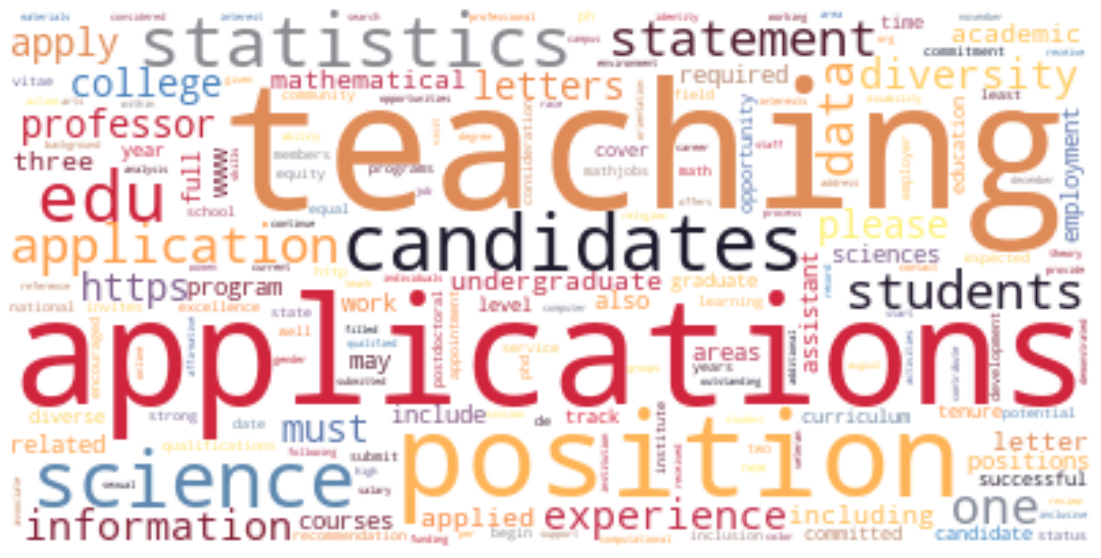

In [91]:
hero.visualization.wordcloud(data, font_path = None, width = 400, height = 200, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

## Task 3: Tokenization, Lemmatization and Word Document Matrix

In [92]:
# Tokenize

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True ))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['center', 'cimat', 'invites', 'applications', 'researchers', 'strong', 'promising', 'track', 'record', 'one', 'tenure', 'track', 'position', 'pure', 'applied', 'start', 'august', 'later', 'dates', 'considered', 'exceptional', 'cases', 'must', 'hold', 'phd', 'show', 'strong', 'promise', 'excellence', 'teaching', 'preference', 'given', 'interests', 'close', 'topics', 'cultivated', 'cimat', 'including', 'emerging', 'topics', 'duties', 'positions', 'include', 'limited', 'carrying', 'teaching', 'one', 'course', 'per', 'semester', 'participating', 'seminars', 'conferences', 'well', 'cimat', 'educational', 'activities', 'must', 'fulfill', 'following', 'requirements', 'strong', 'teaching', 'record', 'according', 'time', 'since', 'graduation', 'resident', 'mexico', 'must', 'belong', 'sistema', 'nacional', 'de', 'investigadores', 'sni', 'cv', 'would', 'allow', 'admitted', 'soon', 'taking', 'appointment', 'teaching', 'experience', 'basic', 'well', 'advanced', 'courses', 'related', 'field', 'exp

In [26]:
!python -m spacy download en

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\en_core_web_sm -->
C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\spacy\data\en
[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')


You do not have sufficient privilege to perform this operation.


In [93]:
%%time
# Lemmatize

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ']) # , 'VERB', 'ADV'

print(data_lemmatized[:2])

['center cimat application researcher strong promising track record tenure track position pure applied start exceptional case strong promise excellence teaching preference interest close topic cimat topic duty position limited carrying course semester seminar conference educational activity requirement strong teaching record time appointment teaching experience basic advanced course field expertise graduate level cimat cimat full time member active prestigious department cimat fruitful collaboration prestigious institution world degree mathematical science level industry government deadline application mail cimat list publication year project publication list electronic copy publication statement philosophy experience interest letter recommendation cimat candidate interview selection process principle legality efficiency objectivity impartiality diversity gender equality', 'image tenure track cat position number salary announcement salary assistant professor level salary finalist role 

In [102]:
custom_stopwords = ["mathematics", "university", "research", "department", "application", "applicant", "candidate", "faculty",
                    "include", "position", "letter", "apply", "submit", "program", "area", "member", "require", "work",
                    'status', 'opportunity', 'start', 'demonstrate', 'equal', 'statement', 'employ', 'receive', 'year', 'include', 'information', 'gender', 'discriminate', 'discrimination', 'disability',
                    'veteran', 'indigenous', 'sexual', 'consider', 'diversity', 'protect', 'affirmative', 'race', 'orientation', 'appointment', 'must', 'date', 'negotiable',
                    'submit', 'available', 'good', 'inclusion', 'inclusive', 'also', 'may', 'job', 'career', 'misconduct', 'religion', 'color', 'harassment', 'misconduct', 'age']
custom_stopwords = lemmatization([custom_stopwords], allowed_postags=['NOUN', 'ADJ'])[0].split(' ') #, 'VERB', 'ADV'
custom_stopwords = default_stopwords.union(custom_stopwords)

In [103]:
# Remove stop words again after lemmatization.
data_lemmatized = hero.remove_stopwords(pd.Series(data_lemmatized), custom_stopwords ).to_list()

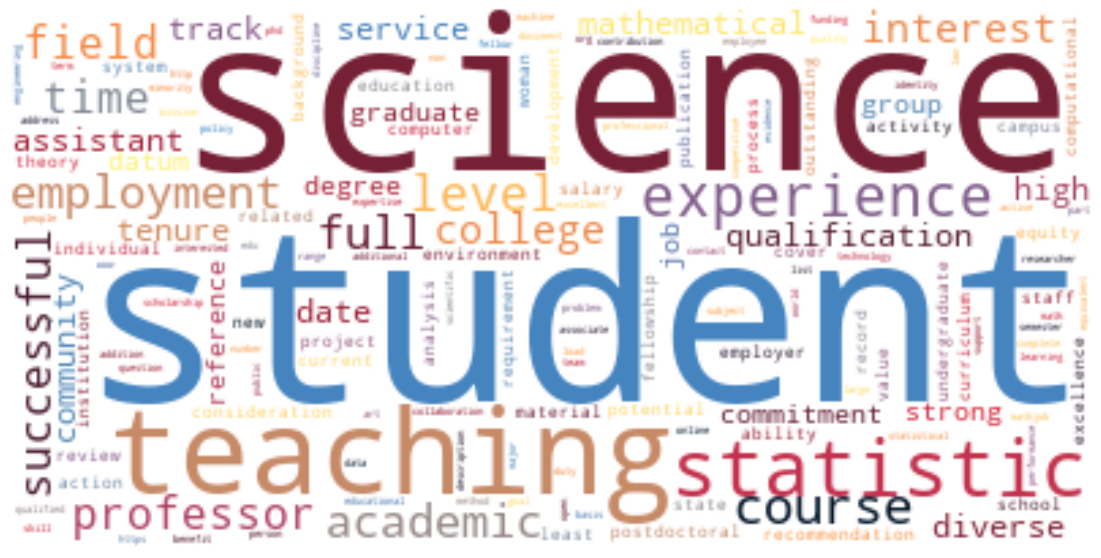

In [104]:
hero.visualization.wordcloud(pd.Series(data_lemmatized), font_path = None, width = 400, height = 200, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

In [105]:
# Word-Document Matrix

vectorizer = CountVectorizer(ngram_range = (1,2),
                             analyzer='word',       
                             min_df=10,                        # minimum number occurences of a word required
                             max_df=0.80,
                             #stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num of characters > 3
                            
data_vectorized =  vectorizer.fit_transform(data_lemmatized)


## Task 4: Build LDA Model with Scikit Learn

In [116]:
%%time
# Build LDA model with Sklearn

lda_model = LatentDirichletAllocation(n_components=40,               # Number of topics
                                      max_iter=10,                   # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,              # Random state
                                      batch_size=128,                # n docs in each learning iter
                                      n_jobs=-1)
                                            
lda_output = lda_model.fit_transform(data_vectorized)                                      

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=40, n_jobs=-1,
                          random_state=100)
Wall time: 2min 21s


In [117]:
#Evaluate model quality

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp((-1) * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))



Log Likelihood:  -5274962.813888572
Perplexity:  1254.035701621529


In [118]:
#Visualize with pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
10     -19.886147   52.318283       1        1  15.976134
20      29.764160   78.794792       2        1   9.891833
13     -59.266708   83.596977       3        1   8.619849
2       25.610712   30.073313       4        1   7.789490
14     -19.522127    2.315754       5        1   4.715938
7       65.331932   -4.010815       6        1   4.561163
6       18.522083  -38.504852       7        1   4.211104
9       84.257339   53.339298       8        1   3.536759
16     -70.365631   28.296638       9        1   3.163458
28      35.877747  216.464111      10        1   3.151420
3       87.870956  116.562935      11        1   2.718666
19      -6.464621  115.615578      12        1   2.582954
37    -191.296997  -65.519547      13        1   2.528856
22     141.897690   20.394705      14        1   2.419100
23     -51.572346  -41.146690      15        1   2.371635
21     -41.309917  209.134811      16        1   1.926650
34     112.571976  -45.034748      17        1   1.802740
8     -118.982605   70.046120      18        1   1.796993
25     151.517395   90.692841      19        1   1.719011
39    -180.522217   25.114670      20        1   1.590793
11    -116.219345   -8.895824      21        1   1.569018
35     -57.211578  146.116364      22        1   1.364205
38    -125.582603  149.815613      23        1   1.310791
32     192.556152  -24.769676      24        1   0.927634
5     -109.216560  -76.696533      25        1   0.913576
27      37.786800  152.920731      26        1   0.888036
29     129.524353  177.943298      27        1   0.858793
15     -61.810902 -275.943878      28        1   0.826470
12    -186.687683  103.990837      29        1   0.809102
0        6.623804 -224.603897      30        1   0.695953
33      60.082371  -96.902504      31        1   0.650265
26     -88.915459 -202.363144      32        1   0.569452
36     148.987946 -134.310776      33        1   0.542611
4       79.851898 -245.025818      34        1   0.461010
18     100.240677 -165.490143      35        1   0.254649
1     -136.676361 -150.343857      36        1   0.233493
31      24.731750 -154.387604      37        1   0.012599
24      -7.712228 -111.365448      38        1   0.012599
17     -26.148232 -167.966034      39        1   0.012599
30     -57.620331 -127.778214      40        1   0.012599, topic_info=                 Term         Freq        Total Category  logprob  loglift
10658       statistic  4537.000000  4537.000000  Default  30.0000  30.0000
9899          science  5839.000000  5839.000000  Default  29.0000  29.0000
10899         student  6630.000000  6630.000000  Default  28.0000  28.0000
2324           course  3744.000000  3744.000000  Default  27.0000  27.0000
6376            level  3212.000000  3212.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
7302   nearby airport     0.007405    14.348617  Topic40  -9.4399   1.4100
10561           staff     0.007405  1249.166119  Topic40  -9.4399  -3.0566
1393    child medical     0.007405    14.348620  Topic40  -9.4400   1.4100
11567       term high     0.007404    14.348617  Topic40  -9.4400   1.4100
6558         liveable     0.007404    14.348616  Topic40  -9.4400   1.4100

[2708 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
1          1  0.314564         ability
1          2  0.209279         ability
1          3  0.063946         ability
1          4  0.032942         ability
1          5  0.054257         ability
...      ...       ...             ...
12579     12  0.113100           young
12579     26  0.073950           young
12584      8  0.960540   young scholar
12589     30  0.906011            zone
12590     30  0.906011  zone operation

[7455 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 

## Task 5: Grid Search for Model Optimization

In [109]:
%%time
# Grid Search for Best LDA Model

from sklearn.model_selection import GridSearchCV

# Define Search Param
params = {"n_components" : [4, 5, 6, 7, 10, 15, 20, 25, 30]}

# Model
lda = LatentDirichletAllocation(random_state=100,
                                n_jobs=-1)

# Grid Search
model = GridSearchCV(lda, param_grid=params)

# Perform Grid Search
model.fit(data_vectorized)

Wall time: 7min 16s


GridSearchCV(estimator=LatentDirichletAllocation(n_jobs=-1, random_state=100),
             param_grid={'n_components': [4, 5, 6, 7, 10, 15, 20, 25, 30]})

In [110]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'n_components': 30}
Best Log Likelihood Score:  -1192763.6134312344
Model Perplexity:  1280.5029247218886


In [111]:
#Visualize with pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\krajarat\.conda\envs\mathjobs\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
10     119.070190   64.655502       1        1  7.374315
2       54.382130  109.799164       2        1  5.729716
14    -161.423965 -103.744957       3        1  5.167455
23    -135.370758   36.673065       4        1  4.815580
7      177.317215  -66.872452       5        1  4.546378
25     -16.436356  142.453796       6        1  4.434146
13      31.052383  204.777573       7        1  4.205950
6      -25.024384 -186.083466       8        1  3.958999
8      -68.157486   20.934038       9        1  3.861562
9       -3.751695    4.961509      10        1  3.635548
1     -114.470009 -179.605469      11        1  3.443167
24    -110.729126  -40.476776      12        1  3.439636
5       42.552418  -42.789406      13        1  3.311533
19     -10.661536   71.922211      14        1  3.055529
0      112.652969  -16.279951      15        1  3.024968
16    -195.499146  -25.853945      16        1  2.971329
29    -207.165924   66.070419      17        1  2.777832
28      10.217649 -110.752060      18        1  2.726934
12     -81.255081   96.477776      19        1  2.706856
20     -77.253441  192.755219      20        1  2.649067
21     182.353027  110.412880      21        1  2.619295
11      89.766510  -93.997673      22        1  2.609223
27     -36.483528  -52.542774      23        1  2.538939
22     -72.052170 -112.144821      24        1  2.465867
18     144.822769 -150.811508      25        1  2.459056
15    -148.475357  135.678162      26        1  2.096395
26     189.811615   17.382956      27        1  1.977162
3       56.555355   33.755768      28        1  1.916578
4       58.988537 -178.376541      29        1  1.860555
17     110.556717  164.236694      30        1  1.620428, topic_info=               Term         Freq        Total Category  logprob  loglift
2324         course  3746.000000  3746.000000  Default  30.0000  30.0000
4486     fellowship  1274.000000  1274.000000  Default  29.0000  29.0000
9899        science  5771.000000  5771.000000  Default  28.0000  28.0000
10658     statistic  4579.000000  4579.000000  Default  27.0000  27.0000
10899       student  6577.000000  6577.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
5219           high    50.215485  2269.574152  Topic30  -5.4748   0.3115
7333            new    45.814993  1317.058560  Topic30  -5.5665   0.7639
11552  tenure track    46.838091  1728.367492  Topic30  -5.5444   0.5142
11820         track    46.688652  2238.713272  Topic30  -5.5476   0.2523
10658     statistic    47.485275  4579.626558  Topic30  -5.5307  -0.4465

[2718 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
1          1  0.111135        ability
1          2  0.030546        ability
1          3  0.049394        ability
1          4  0.013648        ability
1          5  0.102687        ability
...      ...       ...            ...
12579     24  0.053141          young
12579     25  0.066426          young
12579     27  0.123996          young
12580     15  0.977875   young fellow
12584     15  0.956883  young scholar

[8678 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 3, 15, 24, 8, 26, 14, 7, 9, 10, 2, 25, 6, 20, 1, 17, 30, 29, 13, 21, 22, 12, 28, 23, 19, 16, 27, 4, 5, 18])

In [38]:
[token.lemma_ for token in nlp("data science")]

['datum', 'science']

In [63]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer,model=model,n_words=20):
  keywords = np.array(vectorizer.get_feature_names())
  topic_keywords = []
  for topic_weights in model.components_:
    topic_keyword_locs = (-topic_weights).argsort()[:n_words]
    topic_keywords.append(keywords.take(topic_keyword_locs))
  return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, model=best_lda_model, n_words=17)        

# Topic - Keywords Dataframe
df_topic_keywords =  pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ["Word" + str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ["Topic" + str(i) for i in range(df_topic_keywords.shape[0])] 
df_topic_keywords

Word0       Word1       Word2       Word3          Word4  \
Topic0       science   statistic       datum     student  computational   
Topic1       student    teaching      course  experience      statistic   
Topic2      teaching  experience       level     student         school   
Topic3       student    teaching      course   statistic     experience   
Topic4  postdoctoral  fellowship  experience  employment           date   
Topic5      teaching     student         job    academic           full   

                Word5      Word6       Word7         Word8      Word9  \
Topic0          field  professor  experience  mathematical   computer   
Topic1        diverse    college      tenure       science      track   
Topic2           high    science    academic     statistic       date   
Topic3     employment    service     college       science     campus   
Topic4           time   teaching  researcher         level   interest   
Topic5  consideration   employer     science    experience  statistic   

              Word10          Word11       Word12      Word13         Word14  \
Topic0          data     statistical         high    teaching  datum science   
Topic1     community      commitment    education    graduate      assistant   
Topic2  mathematical      successful       career      theory       activity   
Topic3          full        graduate    reference       state       academic   
Topic4         group  recommendation  requirement        full    publication   
Topic5        degree         trading   successful  employment          field   

           Word15        Word16  
Topic0     method         level  
Topic1      level  tenure track  
Topic2      group   development  
Topic3  professor     community  
Topic4     theory         field  
Topic5  professor          date

In [61]:
generated_topic_probabilities = best_lda_model.transform(data_vectorized)
generated_topics = np.argmax(generated_topic_probabilities, axis = 1)

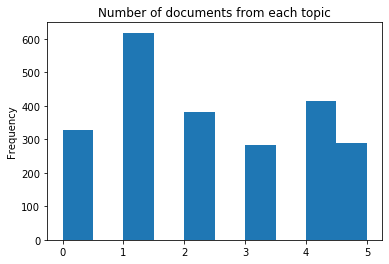

In [62]:
pd.Series(generated_topics).plot.hist(title="Number of documents from each topic")

In [65]:
df["Topic"] = generated_topics

In [66]:
df2 = df[['Title', 'Topic', 'Description', 'Creator', 'Country']][df['Topic'] ==5].sample(10)
df2

Title  Topic  \
1286  Undergraduate and Graduate Teaching, Assistant...      5   
1468                             Mathematics, Professor      5   
530                              Mathematics, Professor      5   
1493                Quantitative Researcher - Amsterdam      5   
225              Teaching, Postdoctoral Teaching Fellow      5   
1956  Database Management Systems, Programming Langu...      5   
1522  Various, Joint Mathematical Sciences and Hoski...      5   
2298  Applied Mathematics with Focus on Information ...      5   
1736                          Assistant Professor(RTPC)      5   
2280  Mathematics, Noether and Taussky-Todd Instruct...      5   

                                            Description  \
1286  The Department of Statistics at the University...   
1468  The Princeton University Mathematics Departmen...   
530   The Princeton University Mathematics Departmen...   
1493     Quantitative Researcher - Amsterdam\n   ===...   
225   The Department of Mathematical Sciences invite...   
1956     BNU-HKBU United International College (UIC)...   
1522  The Department of Mathematical Sciences and th...   
2298  Tenure-Track Assistant Professor - Applied Mat...   
1736  The Department of Mathematics in the Dana and ...   
2280     The Department of Mathematics at the Califo...   

                                                Creator Country  
1286   University of Missouri, Department of Statistics      US  
1468       Princeton University, Mathematics Department      US  
530        Princeton University, Mathematics Department      US  
1493                                  Radix Trading LLC      NL  
225   Carnegie Mellon University, Mathematical Sciences      US  
1956  BNU-HKBU United International College, Divisio...      CN  
1522  Carnegie Mellon University, Mathematical Sciences      US  
2298   University of Houston, Department of Mathematics      US  
1736  University of Southern California, LAS - Dept....      US  
2280  California Institute of Technology, Mathematic...      US

In [67]:
df2.loc[1468]['Title']

'Mathematics, Professor'

In [71]:
df2.loc[2298]['Description']

'Tenure-Track Assistant Professor - Applied Mathematics with Focus on\n   Information Science The Mathematics Department at the University of\n   Houston invites applications from candidates working at the interface\n   of applied mathematics with a focus on information science for a\n   tenure-track Assistant Professor position. We are particularly\n   interested in someone with expertise in information science who would\n   continue to broaden the research performed in the existing research\n   teams at the Mathematics Department and develop strategic connections\n   with other departments at UH in mission-critical areas related to\n   advanced computing and information sciences, artificial intelligence &\n   machine learning. The Mathematics Department is seeking outstanding\n   candidates with the potential for exceptional research, excellence in\n   teaching, and a clear commitment to enhancing the diversity of the\n   faculty, graduate and undergraduate student population. The Un

In [ ]:
df2 = df[['Title', 'Topic', 'Description', 'Creator', 'Country']][df['Topic'] == 1].sample(10)
df2

In [ ]:
df2.loc[13]['Description']

In [ ]:
df2 = df[['Title', 'Topic', 'Description', 'Creator', 'Country']][df['Topic'] == 3].sample(10)
df2

In [ ]:
generated_topic_probabilities[293]

In [ ]:
df2.loc[279]['Description']

In [ ]:
df.loc[35]['Description']

## Task 6: Gensim based model

In [ ]:
corpus_vect_gensim = gensim.matutils.Sparse2Corpus(data_vectorized, documents_columns=False)
id2word = dict((v,k) for k,v in vectorizer.vocabulary_.items())

In [ ]:
from gensim.models.ldamodel import LdaModel

# Train the model on the corpus. Use parameters we obtained from tuning the scikit-learn model.
lda = LdaModel(corpus_vect_gensim, 
               num_topics=model.best_params_['n_components'], 
               id2word=Dictionary.from_corpus(corpus_vect_gensim, id2word=id2word),
               decay = model.best_params_['learning_decay'], 
               random_state=100, update_every=1,
               chunksize=1500, 
               passes=5, iterations=10,
               alpha='asymmetric', eta=1/100,
               per_word_topics=True
              )

In [ ]:
# Show words from 
n_topics=5
n_top_words = 25
for index, topic in lda.show_topics(formatted=False, num_words= n_top_words):
        print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))

In [ ]:
lda?

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_vect_gensim, Dictionary.from_corpus(corpus_vect_gensim, id2word=id2word), mds='tsne')
panel

In [ ]:
LatentDirichletAllocation?

In [ ]:
LdaModel?